# Chatbot Component 2 - Named Entity Recognition (part 1)

### CoQA - A Conversational Question Answering Challenge

https://stanfordnlp.github.io/coqa/ 

https://paperswithcode.com/dataset/coqa


This notebook concerns looking at the above dataset, and includes the following: 
* A through exploratory data analysis
* pre-processing e.g. stemming vs lemmatisation
* visualisations 



###### Student: Brandon Charles (6300028)

In [56]:
import os
import re
import nltk

import pandas as pd
import spacy
import lemminflect # spacy add-on
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer 


# sys.path.append
os.getcwd()

'/Volumes/T7/MSc DS 22/Natural Language Processing/chatbot_nlp_assignment/experimentation/notebooks/named_entity_recognition'

In [11]:
# get path of current notebook
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
# locate data files
data_dir = os.path.join(ipynb_path, '../../data/raw/')
df = pd.read_json(f'{data_dir}/coqa-train-v1.0.json', encoding = 'utf-8-sig')
df.head(3)

,version,data
0,1,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
1,1,"{'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7..."
2,1,"{'source': 'gutenberg', 'id': '3bdcf01ogxu7zdn..."


In [12]:
print(df.version.unique()) 
# all version 1 so unnecessary -> can drop
df.drop(columns='version', inplace=True)

[1]


In [13]:
df.describe()  # summary statistics
# there are 7199 rows in total, which are all unique
# this represents 7199 unique conversations

,data
count,7199
unique,7199
top,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
freq,1


In [14]:
unique_convos = int(df.describe().loc['unique'])
f'{unique_convos} distinct conversations'

'7199 conversations'

In [15]:
df.isnull().sum() # zero na/null values

data    0
dtype: int64

### Let's look at first document within corpus

In [20]:
ex = df.data[0] # looking at 1st example
ex.keys() # keys in 1st element

dict_keys(['source', 'id', 'filename', 'story', 'questions', 'answers', 'name'])

In [19]:
print(f"Name: {ex['name']}\nSource: from {ex['source']}")
# ex['filename'] seems to be same as name

Name: Vatican_Library.txt
Source: from wikipedia


In [24]:
# view questions 
questions = ex['questions']
answers = ex['answers']
print(f'There are {len(questions)} questions and {len(answers)} answers')
# 20 questions

There are 20 questions and 20 answers


let's look at an example question & answer

In [25]:
print(f'question: {questions[0]}\nanswer: {answers[0]}')
# first question

question: {'input_text': 'When was the Vat formally opened?', 'turn_id': 1}
answer: {'span_start': 151, 'span_end': 179, 'span_text': 'Formally established in 1475', 'input_text': 'It was formally established in 1475', 'turn_id': 1}


In [35]:
# this is the text it pertains to
ex['story']

'The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. \n\nThe Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. \n\nIn March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. \n\nThe Vatican Secret Archives were separated from the library at the beginning of t

In [36]:
# generate lists of all questions & answers in document respectively
q_list = [q['input_text'] for q in questions]
ans_list = [a['input_text'] for a in answers]
# visualise as dataframe
qa_df = pd.DataFrame(data= {'questions': q_list, 'answers': ans_list})
# view first 5 items
qa_df.head()

,questions,answers
0,When was the Vat formally opened?,It was formally established in 1475
1,what is the library for?,research
2,for what subjects?,"history, and law"
3,and?,"philosophy, science and theology"
4,what was started in 2014?,a project


## Visualising the entire corpus

In [37]:
# name, story, source, questions, answers 
def dataset_to_df():
    "this function converts aggregates all corpus documents into a data frame"
    convo_dict = dict()
    names = []
    corpus = []
    sources = []
    questions_li = []
    answers_li = []
    for convo in df.data:
        names.append(convo['name'])
        corpus.append(convo['story'])
        sources.append(convo['source'])
        questions = [q['input_text'] for q in convo['questions']]
        questions_li.append(questions)
        answers = [a['input_text'] for a in convo['answers']]
        answers_li.append(answers)
    
    convo_dict = {'names': names, 'corpus': corpus, 'sources': sources, 'questions': questions_li, 'answers': answers_li}
    return pd.DataFrame.from_dict(convo_dict)
    # convo_dict['ques']

df2 = dataset_to_df()
df2.head(3)

,names,corpus,sources,questions,answers
0,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",wikipedia,"[When was the Vat formally opened?, what is th...","[It was formally established in 1475, research..."
1,cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...,New York (CNN) -- More than 80 Michael Jackson...,cnn,"[Where was the Auction held?, How much did the...","[Hard Rock Cafe, $2 million., $120,000, Hoffma..."
2,data/gutenberg/txt/Zane Grey___Riders of the P...,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",gutenberg,"[What did Venters call Lassiter?, Who asked La...","[gun-man, Jane, Yes, to take charge of her cat..."


In [38]:
df2.describe() # summary stats

,names,corpus,sources,questions,answers
count,7199,7199,7199,7199,7199
unique,6600,6605,5,7199,7191
top,cnn_0da77c1f367a7874bcf56f43671c15d607c02910.s...,"New York (CNN) -- A self-described ""ex-madam"" ...",race,"[When was the Vat formally opened?, what is th...",[unknown]
freq,11,11,1711,1,6


In [39]:
df2.isnull().sum() # verifying no nulls/na values

names        0
corpus       0
sources      0
questions    0
answers      0
dtype: int64

In [40]:
df2.sources.value_counts(normalize=True) 
# 5 different sources, fewest come from mctests

race         0.237672
cnn          0.236422
wikipedia    0.225170
gutenberg    0.224337
mctest       0.076399
Name: sources, dtype: float64

In [41]:
dup_rows = df2.copy()[df2.copy().duplicated(subset=['names', 'corpus'])] 
dup_rows.sort_values(by='names', inplace=True)
dup_rows.head(4)
# there's rows using the same corpus from the same file names
# these appear to pertain to  diff sets of questions and answers

,names,corpus,sources,questions,answers
5742,2008_Summer_Olympics_torch_relay2008_Summer_Ol...,The 2008 Summer Olympics torch relay was run f...,wikipedia,"[where is the birthplace of the olympics?, how...","[Olympia, Greece, Six, yes, Panathinaiko Stadi..."
6109,2008_Summer_Olympics_torch_relay2008_Summer_Ol...,The 2008 Summer Olympics torch relay was run f...,wikipedia,"[Where did the Olympics begin?, In what countr...","[Olympia, Greece, Journey of Harmony, the orga..."
2122,2008_Summer_Olympics_torch_relay2008_Summer_Ol...,The 2008 Summer Olympics torch relay was run f...,wikipedia,"[When was the race?, What was it for?, What wa...","[March 24 until August 8, 2008, Summer Olympic..."
6939,2008_Summer_Olympics_torch_relay2008_Summer_Ol...,The 2008 Summer Olympics torch relay was run f...,wikipedia,"[When did the relay start?, Where?, Why is tha...","[March 24, Olympia, Greece, It is the birthpla..."


### Named Entity Recognition with spacy

In [57]:
# looking at the first corpus example again
excerpt = df2.iloc[0].corpus 
nlp = spacy.load('en_core_web_sm')
doc = nlp(excerpt) # preprocesses text with spacy pipeline - useful!
# style = 'ent' represents entity recognition
spacy.displacy.render(doc, style='ent', jupyter=True) 
# print(doc)

### Tokenisation

In [58]:
# tokenise & remove most punctuation 
# using regex to tokenise and remove tokens
list_of_words = [re.sub('[,\.!?()]', '', x) for x in excerpt.split()] 
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
vocab = [word.lower() for word in list_of_words if word.lower() not in spacy_stopwords]
# test

In [59]:
print(vocab)

['vatican', 'apostolic', 'library', '', 'commonly', 'called', 'vatican', 'library', 'simply', 'vat', 'library', 'holy', 'located', 'vatican', 'city', 'formally', 'established', '1475', 'older', 'oldest', 'libraries', 'world', 'contains', 'significant', 'collections', 'historical', 'texts', '75000', 'codices', 'history', '11', 'million', 'printed', 'books', 'include', '8500', 'incunabula', 'vatican', 'library', 'research', 'library', 'history', 'law', 'philosophy', 'science', 'theology', 'vatican', 'library', 'open', 'document', 'qualifications', 'research', 'needs', 'photocopies', 'private', 'study', 'pages', 'books', 'published', '1801', '1990', 'requested', 'person', 'mail', 'march', '2014', 'vatican', 'library', 'began', 'initial', 'four-year', 'project', 'digitising', 'collection', 'manuscripts', 'available', 'online', 'vatican', 'secret', 'archives', 'separated', 'library', 'beginning', '17th', 'century;', 'contain', '150000', 'items', 'scholars', 'traditionally', 'divided', 'hist

In [61]:
print(f"Number of Tokens: {len(list_of_words)}")
# set gets distinct tokens
distinct_vocab = set(vocab)
print(f"Vocabulary length: {len(distinct_vocab)}")
# quite a lot of repeated words - let's visualise the most common ones...

Number of Tokens: 218
Vocabulary length: 89


In [62]:
avg_token_len = sum([len(word) for word in distinct_vocab]) / len(distinct_vocab)
f'Average word length: {round(avg_token_len, 2)}'

'Average word length: 6.99'

In [63]:
wordfreqdist = nltk.FreqDist(vocab)
most_common = wordfreqdist.most_common(10) # top 10!
print(most_common)

[('library', 10), ('vatican', 8), ('history', 3), ('significant', 2), ('books', 2), ('research', 2), ('initial', 2), ('pre-lateran', 2), ('period', 2), ('days', 2)]


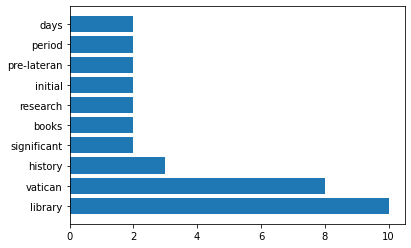

In [64]:

y = [i[1] for i in most_common] # words
x = [i[0] for i in most_common]
plt.barh(range(len(most_common)), y, align='center')
plt.yticks(range(len(most_common)), x)
plt.show()

### zipf's law

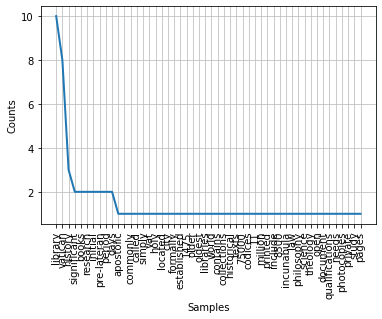

In [94]:
wordfreqdist.plot(50)
plt.show()
# Even though we can see the plot follows the trend of Zipf’s Law, but it looks like it has more area above the expected Zipf curve in higher ranked words.

### Stemming and Lemmatisation


`Stemming` produces the base root of a word in a slightly more 'crude' or 'heuristic' way (than lemmatisation) by chopping off word endings. This is done with the assumption that the remaining word is what we are actually looking for, but often results in derivational affixes also being removed which can be problematic.

`Lemmatisation `is an algorithmic manner of finding the dictionary form of a word semantically i.e. the `lemma`. It more elegantly utilises a vocabulary and morpoholigical word analysis in its attempt to only remove inflectional endings. As such, it's the best practice to use lemmatisation to get the root word correctly.

In [86]:
def stem_vs_lem(test_str = 'slowest'):
    "function to test 2 different stemmers and lemmatisers on test input"
    porter_stemmer = PorterStemmer() 
    snowball_stemmer = SnowballStemmer("english") 
    # initialise lemmatiser via spacy
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(test_str)
    # doc = nlp('I got the data')
    for token in doc:
        # print('%-6s %-6s %s' % (token.text, token.lemma_, token._.lemma()))
        print(f'token: {token.text}\n')
        print(f'porter stemmer: {porter_stemmer.stem(test_str)}') 
        print(f'snowball stemmer: {snowball_stemmer.stem(test_str)}')
        print(f'spacy lemmatiser: {token.lemma_}\nLemminflect lemmatiser: {token._.lemma()}')


In [87]:
inputs = ['biggest', 'fastest', 'best']
for inp in inputs:
    stem_vs_lem(test_str=inp)

token: biggest

porter stemmer: biggest
snowball stemmer: biggest
spacy lemmatiser: big
Lemminflect lemmatiser: big
token: fastest

porter stemmer: fastest
snowball stemmer: fastest
spacy lemmatiser: fast
Lemminflect lemmatiser: fast
token: best

porter stemmer: best
snowball stemmer: best
spacy lemmatiser: good
Lemminflect lemmatiser: good


In [81]:
#  Lemminflect which works as an add-in pipeline component for SpaCy which can give better results.
def lemmatise(token):
    "function to lemmatise specifically"
    nlp = spacy.load('en_core_web_sm')
    for token in nlp(token):
        # return token._.lemma()
        print(f'token: {token.text}\nlemma 1 (spaCy default): {token.lemma_}\nlemma 2 (Lemminflect): {token._.lemma()}')

In [88]:
lemmatise('running')

token: running
lemma 1 (spaCy default): run
lemma 2 (Lemminflect): run
